
 # ReFrameWork

In this notebook, I'm attempting to reimplement my personal dolfin-interface, which creates a more clear relation between various types.

## Poisson Equation

$$
    -div(D*\nabla u) = f
$$
with $f = -D(6x + 6y)$, which means that $u = x^3 + y^3$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import inspect
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Dict, Any, List, Optional, Union, TypeAlias

import dolfin as df
import matplotlib.pyplot as plt

import ufl
from dolfin import (
    TrialFunction,
    TestFunction,
    UnitSquareMesh,
    Mesh,
    RectangleMesh,
    CompiledSubDomain,
    DOLFIN_EPS,
    Point,
    MeshFunction,
    Expression,
    plot,
    XDMFFile,
    FunctionSpace,
    DirichletBC,
    Measure,
    FacetNormal,
    Constant,
    FiniteElement,
    lhs,
    rhs,
    Function,
    assemble
)

import numpy as np
from dolfin import inner, grad, dx, div

from dolfin.function.argument import Argument
from dolfin.cpp.mesh import MeshFunctionSizet
from ufl import Coefficient, Form
from ufl.indexed import Indexed
from ufl.finiteelement.finiteelementbase import FiniteElementBase
from ufl import FacetNormal, Cell
import ulfy

import ufl
from pantarei import forms, solvers, mms, boundary
import sympy as sp

# from multirat.timekeeper import TimeKeeper

Potentially relevant snipper if I want to use general domains.

```python
from dolfin.cpp.mesh import Facet, facets
from dolfin import SpatialCoordinate

domain = MMSDomain(1)
for facet in facets(domain):
    if facet.exterior():
        print(facet.normal().array())
```

In [3]:
def simpleplot(u, **kwargs):
    c = plot(u, **kwargs)
    plt.colorbar(c)
    plt.show()

In [4]:
import ufl
import dolfin as df
from pantarei import forms, solvers, mms, boundary

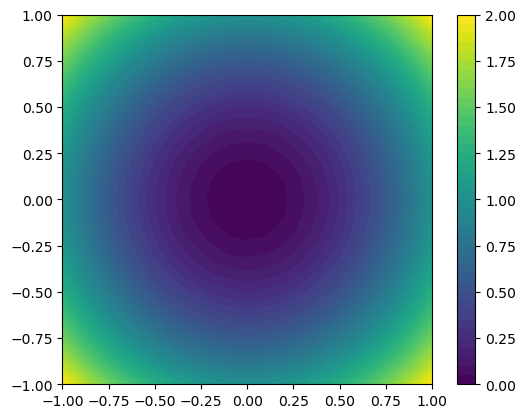

In [5]:
domain = mms.MMSDomain(20)
element = df.FiniteElement(family="CG", cell=ufl.Cell("triangle"), degree=1)
parameters = {
    "D": 1.0,
    "boundary_transfer": 0.2
}

coefficients = {
    **parameters,
    "uD": df.Expression("pow(x[0], 2) + pow(x[1], 2)", degree=2),
    "uN_l": df.Expression("2*D*x[0]", degree=1, D=df.Constant(parameters["D"])),
    "uN_r": df.Expression("-2*D*x[0]", degree=1, D=df.Constant(parameters["D"])),
    "source": df.Expression("-4*D", D=df.Constant(parameters["D"]), degree=0)
}

form = forms.poisson_form()
boundaries = [
    boundary.NeumannBoundary(coefficients["uN_l"], 1),
    boundary.NeumannBoundary(coefficients["uN_r"], 2),
    boundary.DirichletBoundary(coefficients["uD"], 3),
    boundary.DirichletBoundary(coefficients["uD"], 4)
]

solver = solvers.StationaryProblemSolver("lu", "none")
poisson = solvers.StationaryProblem(
    domain,
    element,
    coefficients,
    form,
    boundaries,
    solver
)
u = poisson.solve()

import matplotlib.pyplot as plt
c = plot(u)
plt.colorbar(c)
plt.show()

## MMS-Solution

In [6]:
import sympy as sp
from dolfin.cpp.la import Matrix

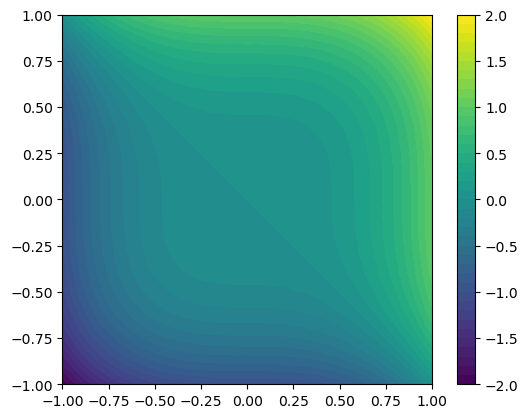

In [7]:
domain = mms.MMSDomain(20)
element = df.FiniteElement(family="CG", cell=ufl.Cell("triangle"), degree=1)

coefficients = {
    "D": 1.0,
    "boundary_transfer": 0.2
}

x, y = sp.symbols("x y")
u_sym = x**3 + y**3

mms_boundaries = [
    mms.MMSNeumannBoundary(1),
    mms.MMSRobinBoundary(coefficients["boundary_transfer"], 2),
    mms.MMSDirichletBoundary(3),
    mms.MMSDirichletBoundary(4)
]

system = mms.PoissonModelSystem()
mms_coefficients = mms.setup_mms_coefficients(u_sym, mms_boundaries, domain, system, coefficients, degree=3)
coefficients["source"] = mms_coefficients.source
boundaries = mms_coefficients.boundaries

form = forms.poisson_form()
solver = solvers.StationaryProblemSolver("lu", "none")
poisson = solvers.StationaryProblem(
    domain,
    element,
    coefficients,
    form,
    boundaries,
    solver,
    name=None
)
u = poisson.solve()

import matplotlib.pyplot as plt
c = plot(u)
plt.colorbar(c)
plt.show()

## Diffusion Equation

In [8]:
from pantarei.boundary import BoundaryData, DirichletBoundary, process_boundary_forms
from pantarei.forms import diffusion_form
from pantarei.timekeeper import TimeKeeper
from typing import Dict, List

In [9]:
from dolfin import *

def sqnorm(*args):
    return sum((xi**2 for xi in args))

In [10]:
dt = 0.1
T = 1.0
time = TimeKeeper(dt, T)

# Diffusion coefficient
D = 2.0

# Placeholder for sympy-generated expressions
mesh_ = UnitSquareMesh(1, 1)
V_ = FunctionSpace(mesh_, "CG", 1)
u_ = Function(V_)
dudt_ = Function(V_)


# Sympy-generated MMS solutions
x, y, t = sp.symbols("x y t")
u_sympy = t * (x**2 + y**2)
u_mms = ulfy.Expression(u_, subs={u_: u_sympy}, degree=5, t=time)
f_mms = ulfy.Expression(dudt_ + div(-D*grad(u_)), subs={u_: u_sympy, dudt_: sp.diff(u_sympy, t)}, degree=2, t=time)

u_expr = Expression(f"t * (x[0]*x[0] + x[1]*x[1])", degree=5, t=time)
f_expr = Expression(f"(x[0]*x[0] + x[1]*x[1]) - 4*{D}*t", degree=2, t=time)

# Define which of the formulations for u, f we should use
f = f_mms
u_true = u_mms
# f = f_expr
# u_true = u_expr

t =  0.0


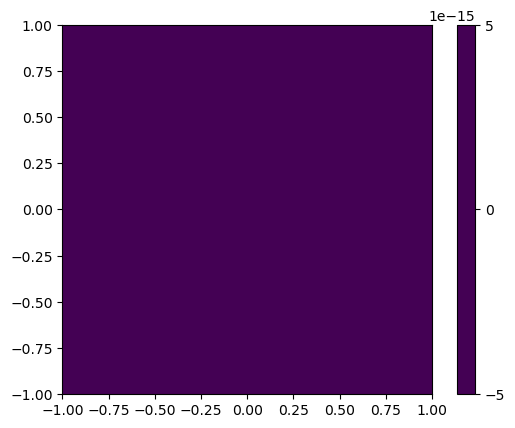

t =  0.1
t =  0.2
t =  0.30000000000000004
t =  0.4
t =  0.5
t =  0.6
t =  0.7
t =  0.7999999999999999
t =  0.8999999999999999
t =  0.9999999999999999


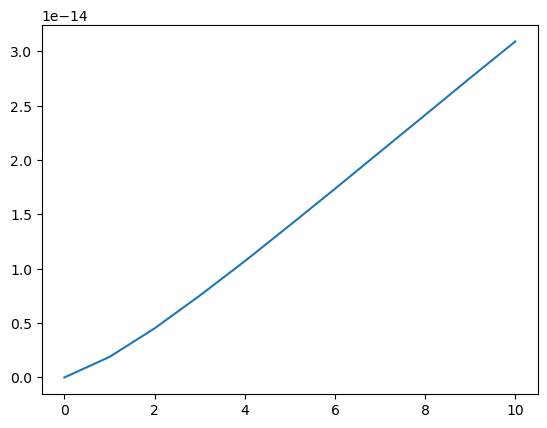

In [11]:
coefficients = {
    "D": D,
    "dt": time.dt,
    "source": f
}

# Define mesh and elements.
n = 20
domain = mms.MMSDomain(n)
element = FiniteElement(family="CG", cell=ufl.Cell("triangle"), degree=2)

boundaries = [
    DirichletBoundary(u_true, 1),
    DirichletBoundary(u_true, 2),
    DirichletBoundary(u_true, 3),
    DirichletBoundary(u_true, 4),
]

V = FunctionSpace(domain, element)

time.reset()
u0 = project(u_true, V)
coefficients["u0"] = u0
dirichlet_bcs = boundary.process_dirichlet(V, domain, boundaries)
F = forms.diffusion_form()(V, coefficients, boundaries)
a, l = lhs(F), rhs(F)
A = assemble(a)

uh = Function(V)
uh.assign(coefficients["u0"])
print("=========")
print("t = ", float(time))
print("=========")
simpleplot(uh, vmax=2)


error = np.nan * np.empty(len(time))
error[0] = errornorm(u_true, uh)
for idx, ti in enumerate(time):
    print("=========")
    print("t = ", float(ti))
    print("=========")
    
    b = assemble(l)
    for bc in dirichlet_bcs:
        bc.apply(A, b)
    df.solve(A, uh.vector(), b)
    
    error[idx+1] = errornorm(u_true, uh)
    coefficients["u0"].assign(uh)
    
plt.plot(error)

In [12]:
from pantarei.computers import BaseComputer
from pantarei.solvers import solve_time_dependent
from pantarei.fenicsstorage import FenicsStorage

In [13]:
time.reset()
if "u0" in coefficients: coefficients.pop("u0")
errorcomputer = BaseComputer({"error": lambda u: errornorm(u_true, u)})



solve_time_dependent(
    domain=domain,
    element=element,
    coefficients=coefficients,
    form=diffusion_form(),
    boundaries=boundaries,
    initial_condition=lambda _, __: u_true,
    time=time,
    solver=solver,
    storage=FenicsStorage("diffusion/results.hdf", "w"),
    name="concentration",
    computer=errorcomputer
)

In [15]:
def read_function(hdffile, name, idx: int = 0):
    file = FenicsStorage(hdffile, "r")
    u = file.read_function(name, None, idx)
    file.close()
    return u

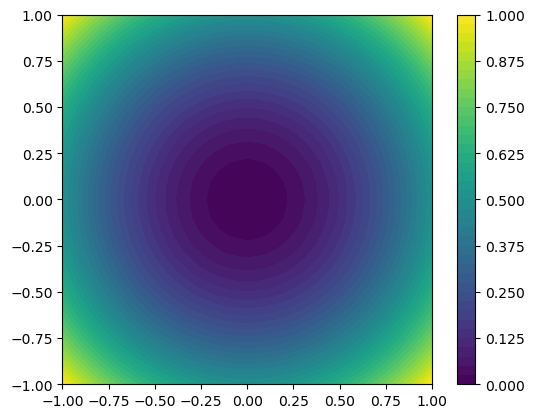

In [16]:
u = read_function("test.hdf", "concentration", 5)
simpleplot(u)

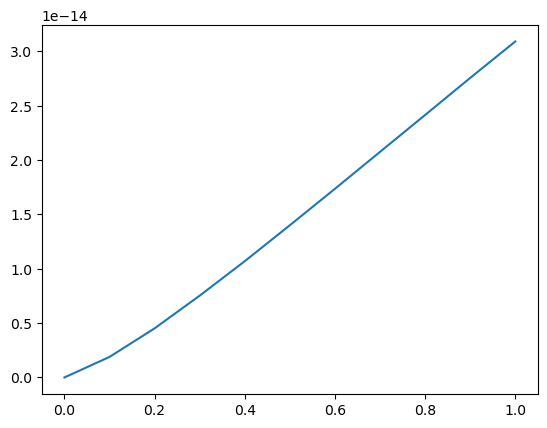

In [17]:
plt.plot(time.as_vector(), errorcomputer.values["error"])
plt.show()

Define mms.MMS solution as sympy expression
```python
# x, y, t = sp.symbols("x y t")
# u_sympy = (1.0-t/T) * (2 - (x**2 + y**2))
# u_sympy = (1.0/(4*sp.pi*D*(t+0.1))) * sp.exp(-(sqnorm(x, y)/(4.0*D*(t+0.1))))
# u_sympy = t * (x**2 + y**2)
```